<a href="https://colab.research.google.com/github/tanaxer01/mov-in-covid/blob/main/cov_predictions_no_sarimax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install unidecode

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from requests import get
from zipfile import ZipFile
from threading import Thread
from unidecode import unidecode
from datetime import datetime, timedelta

# GITHUB Datasets

## base

In [ ]:
datasets = {
  # DP1
  "dp1_contagios": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto1/Covid-19_std.csv",
  # DP7
  "dp7_pcr": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto7/PCR_std.csv",
  # DP20
  "dp20_camas": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto20/NumeroVentiladores_std.csv",
  # DP51
  "dp51_difs": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto51/ISCI_std.csv",
  # DP82
  "dp82_weeks": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto82/ISCI_weeks.csv",
  "dp82_weekends": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto82/ISCI_weekends.csv",
}

if not os.path.exists("./datos"):
  os.mkdir("./datos")

for name, url in datasets.items():
  if not os.path.exists(f"./datos/{name}.csv"):
    with open(f"./datos/{name}.csv", "w") as archivo:
      archivo.write( get(url).content.decode() ) 

## DP1

In [ ]:
DataProduct1 = pd.read_csv("./datos/dp1_contagios.csv", parse_dates=["Fecha"])

# Just RM
DataProduct1 = DataProduct1[ (DataProduct1["Codigo region"] == 13) & (DataProduct1["Comuna"] != "Desconocido Metropolitana") ]
# Remove garbage
DataProduct1 = DataProduct1.set_index("Fecha").drop(columns=["Region", "Codigo region"])
DataProduct1['Comuna'] = DataProduct1['Comuna'].apply(lambda x: unidecode(x).lower())

######### ######### ######### ######### ######### ######### ######### ######### #########

## cov_all: Cantidad de contagios acumulativa x comuna(columnas) y fecha(index)
cov_all = DataProduct1.pivot_table(values="Casos confirmados", index="Fecha", columns="Comuna").rename(columns=lambda x: unidecode(x).lower())  
## cov_new: Cantidad de contagios nuevos x comuna(columnas) y fecha(index)
cov_new = cov_all.subtract( cov_all.shift(periods=1, fill_value=0) )
cov_new.head(1)

Comuna,alhue,buin,calera de tango,cerrillos,cerro navia,colina,conchali,curacavi,el bosque,el monte,...,san bernardo,san joaquin,san jose de maipo,san miguel,san pedro,san ramon,santiago,talagante,tiltil,vitacura
Fecha,,,,,,,,,,,,,,,,,,,,,
2020-03-30,0.0,7.0,6.0,0.0,19.0,32.0,14.0,5.0,18.0,0.0,...,32.0,13.0,0.0,25.0,0.0,0.0,127.0,0.0,0.0,83.0


## DP7

In [ ]:
DataProduct7 = pd.read_csv("./datos/dp7_pcr.csv", parse_dates=["fecha"])

# Just RM
DataProduct7 = DataProduct7[ DataProduct7['Codigo region'] == 13 ]
DataProduct7 = DataProduct7.set_index("fecha").drop(columns=["Region", "Codigo region", "Poblacion"])

######### ######### ######### ######### ######### ######### ######### ######### #########

# cant_pcr: cantidad de pcr realizados por dia a nivel regional.
cant_pcr = DataProduct7["numero"]
cant_pcr.head(5)

fecha
2020-04-09    5383.0
2020-04-10    3185.0
2020-04-11    2105.0
2020-04-12    3861.0
2020-04-13    1850.0
Name: numero, dtype: float64

## DP20

In [ ]:
DataProduct20 = pd.read_csv("./datos/dp20_camas.csv", parse_dates=["fecha"])
DataProduct20 = DataProduct20.set_index("fecha")

######### ######### ######### ######### ######### ######### ######### ######### #########

# camas_criticas: Dataset que contiene el numero de camas criticas disp y ocupadas a nivel nacional.
camas_criticas = pd.DataFrame({ 
    "totales": DataProduct20[ DataProduct20.Ventiladores == "total" ]["numero"],
    "disponibles": DataProduct20[ DataProduct20.Ventiladores == "disponibles" ]["numero"],
    "ocupados": DataProduct20[ DataProduct20.Ventiladores == "ocupados" ]["numero"]
})

camas_criticas.head(3)

,totales,disponibles,ocupados
fecha,,,
2020-04-14,1550,564,986
2020-04-15,1563,577,986
2020-04-16,1582,569,1013


## DP51

In [ ]:
DataProduct51 = pd.read_csv("./datos/dp51_difs.csv", parse_dates=["Fecha"])
DataProduct51 = DataProduct51[ DataProduct51['Codigo region'] == 13 ].drop(columns=['Region', 'Codigo region', 'Cartodb id'])

parse_diff = lambda x: (100 + sum([ int(i)  for i in x[1:-2].replace('%','').split(",") ])/2)/ 100

DataProduct51['Comuna'] = DataProduct51['Comuna'].apply(lambda x: unidecode(x).lower()) 

DataProduct51['Salida']  = DataProduct51['Dif salida'].map(parse_diff)
DataProduct51['Entrada'] = DataProduct51['Dif entrada'].map(parse_diff)

######### ######### ######### ######### ######### ######### ######### ######### #########

# IM_salida: Valor promedio de la variación porcentual de salida entre las manzanas censales de cada comuna.
IM_salida = DataProduct51.groupby(['Fecha', 'Comuna'], as_index=False)["Salida"].mean()
IM_salida = IM_salida.pivot_table(values="Salida", columns="Comuna", index="Fecha")
# IM_entrada: Valor promedio de la variación porcentual de entrada entre las manzanas censales de cada comuna.
IM_entrada = DataProduct51.groupby(['Fecha', 'Comuna'], as_index=False)["Entrada"].mean()
IM_entrada = IM_entrada.pivot_table(values="Entrada", columns="Comuna", index="Fecha")

IM_salida.head(2)

Comuna,alhue,buin,calera de tango,cerrillos,cerro navia,colina,conchali,curacavi,el bosque,el monte,...,renca,san bernardo,san joaquin,san jose de maipo,san miguel,san ramon,santiago,talagante,tiltil,vitacura
Fecha,,,,,,,,,,,,,,,,,,,,,
2020-03-02,0.995,1.072143,1.265,1.149286,1.175,1.2875,1.140385,1.29875,1.265,1.085,...,1.1975,1.173676,1.139643,0.995,1.345417,1.031818,1.101744,1.157,1.319,1.026154
2020-03-09,0.995,1.072143,1.265,1.149286,1.175,1.2875,1.140385,1.29875,1.265,1.085,...,1.1975,1.173676,1.139643,0.995,1.332500,1.031818,1.101744,1.157,1.319,1.026154


## DP82

In [ ]:
DataProduct82a = pd.read_csv('./datos/dp82_weeks.csv', parse_dates=["fecha_inicio"])
DataProduct82b = pd.read_csv('./datos/dp82_weekends.csv', parse_dates=["fecha_inicio"])

DataProduct82 = pd.concat([DataProduct82a, DataProduct82b]).sort_values("fecha_inicio")

DataProduct82 = DataProduct82[ DataProduct82['region'] == 13 ].drop(columns=['region'])
DataProduct82["paso"] = DataProduct82["paso"].fillna(method="ffill")
DataProduct82["nom_comuna"] = DataProduct82["nom_comuna"].apply(lambda x: unidecode(x).lower())

# ######### ######### ######### ######### ######### ######### ######### ######### #########

# paso_a_paso: Etapas del paso a paso de cada comuna por dia.
paso_a_paso = DataProduct82.pivot_table(values='paso', index='fecha_inicio', columns='nom_comuna')

# # var_salidas: Variación del IM de salida de cada comuna por dia.
var_salidas = DataProduct82.pivot_table(values="var_salidas", index="fecha_inicio", columns="nom_comuna")

[ i for i in DataProduct82["nom_comuna"].drop_duplicates() if 'san' in i]

['santiago',
 'san joaquin',
 'san miguel',
 'san bernardo',
 'san jose de maipo',
 'san ramon']

# DRIVE Dataset

In [ ]:
DATA_DIR = "drive/MyDrive/Datasets/"
FILES = {
  "01": "01_enero_18_24.csv",
  "02": "02_febrero_08_14.csv",
  "03": "03_marzo_15_21.csv",
  # "04": "04_abril_12_18.csv",
  "05": "05_mayo_10_16.csv",
  "06": "06_junio_07_13.csv",
  "07": "07_julio_05_11.csv"
}

PROCESS = True 

In [ ]:
import dask.dataframe as dd

principal_cols = ['netapa', "tiempo_subida", "comuna_subida", "comuna_bajada" ]
final = pd.DataFrame()
for nombre, archivo in FILES.items():
  print( nombre )
  mes = dd.read_csv(DATA_DIR + archivo, usecols=principal_cols).dropna()
  # FILTER
  filtro = (mes.netapa == 1) & (mes.tiempo_subida.str[11:13].isin(["06", "07", "08"]))
  mes = mes[filtro]

  # CONVERT
  mes["comuna_subida"] = mes["comuna_subida"].apply(lambda x: unidecode(x.lower()), meta=('comuna_subida', 'object'))
  mes["comuna_bajada"] = mes["comuna_bajada"].apply(lambda x: unidecode(x.lower()), meta=('comuna_bajada', 'object'))

  mes["tiempo_subida"] = mes["tiempo_subida"].apply(lambda x: x[5:10], meta=('tiempo_subida', 'object'))

  # GROUPBY
  dia = mes.groupby([ "tiempo_subida", "comuna_subida", "comuna_bajada" ])['netapa'].count()
  # display(dia.dask)
  final = pd.concat([final, dia.compute(num_workers = 4).reset_index()])

01
02
03
05
06
07


In [ ]:
# mes = dia
# mes["tiempo_subida"] = mes["tiempo_subida"].apply(lambda x: str(x)+"/01")  

# mes[ mes.tiempo_subida.isin(["06", "07", "08", "09"]) ]
# mes
final[ (final.tiempo_subida.str.contains("01-18")) ]["netapa"].sum()

499884

### Calculo Población flotante - Threads

In [ ]:
import concurrent.futures
import logging

def process_file(input_path, output_path):
  logging.debug(f"[+] processing {input_path}")
  # Datos principales
  principal_cols = [ 'netapa', 'tiempo_subida', 'comuna_subida', 'comuna_bajada' ] 
  # Datos segundarios (En vola usarlos)
  secondary_cols = [ 'dist_eucl_paraderos', 'periodosubida']

  date = lambda x: x.tiempo_subida[5:10]

  with ZipFile(input_path) as zip:
    mes = pd.read_csv(zip.open(zip.namelist()[0]), usecols=principal_cols, na_values="-", chunksize=100000, 
                      convert = { 'comuna_subida':},
                      dtype   = { 'netapa': "int16", "tiempo_subida": "object", "comuna_subida": "category", "comuna_bajada": "category" })

  rows = pd.DataFrame(columns=["tiempo_subida", "comuna_subida", "comuna_bajada", "netapa"])
  for num, chunk in enumerate(mes):
    temp = chunk["tiempo_subida"].str[10:13].astype(int)
    chunk["tiempo_subida"] = chunk.tiempo_subida.apply(lambda x: x[5:10])
    chunk = chunk[ (chunk.netapa == 1) & (temp < 10) & (temp > 5) ]

    suma = chunk.groupby(["tiempo_subida", "comuna_subida", "comuna_bajada"], as_index=False).count()
    rows = rows.append(suma, ignore_index=True)

  logging.debug(f"[+] ended {input_path}")
  rows = rows.rename(columns={"netapa": "viajes"})
  rows.to_csv(output_path, index=False)
  
  


# if PROCESS:
#   with concurrent.futures.ThreadPoolExecutor(max_workers = 7) as executor:
#     #futures = [ executor.submit(process_file, DATA_DIR+FILES["enero"], f"./calcs/enero_nums.csv") ]
#     futures = [ executor.submit(process_file, DATA_DIR+j, DATA_DIR+f"calcs/{i}_nums.csv") for i, j in FILES.items() ] 
  
#     done, not_done = concurrent.futures.wait(futures, return_when=concurrent.futures.ALL_COMPLETED) 
#     print(done)
process_file( DATA_DIR+FILES["enero"], "./enero_nums.csv")

### Importación numeros

In [ ]:
import os

viajes = pd.DataFrame(columns=["tiempo_subida", "comuna_subida", "comuna_bajada", "viajes"])
for i in os.listdir(DATA_DIR + "calcs"):
  curr = pd.read_csv(DATA_DIR+"calcs/"+i)
  
  mes  = curr.tiempo_subida.iloc[0][:2]

  # FIX WRONGLY WRITTEN COMMUNES
  curr["comuna_subida"] = curr["comuna_subida"].map(unidecode)
  curr["comuna_bajada"] = curr["comuna_bajada"].map(unidecode)

  # GROUP BY date, source & destiny
  curr = curr.groupby(["tiempo_subida", "comuna_subida", "comuna_bajada"], as_index=False).sum()
  viajes = viajes.append( curr )

# pob_flot = viajes[viajes["comuna_subida"] == "santiago"].groupby([ "tiempo_subida" ], as_index=False)["viajes"].sum()
# pob_flot["tiempo_subida"] = suma["tiempo_subida"].apply(lambda x: datetime.strptime("2021-"+x, "%Y-%m-%d"))

# suma
viajes

,tiempo_subida,comuna_subida,comuna_bajada,viajes
0,04-12,CERRILLOS,CERRILLOS,1096
1,04-12,CERRILLOS,CONCHALI,12
2,04-12,CERRILLOS,EL BOSQUE,4
3,04-12,CERRILLOS,ESTACION CENTRAL,1096
4,04-12,CERRILLOS,INDEPENDENCIA,20
...,...,...,...,...
6399,07-11,VITACURA,QUINTA NORMAL,26
6400,07-11,VITACURA,RECOLETA,24
6401,07-11,VITACURA,SAN RAMON,7
6402,07-11,VITACURA,SANTIAGO,114


# Join Data

In [ ]:
datasets = { 
    "nuevos_contagios":  cov_new.santiago,         # Cada 2/3 dias
    "pcrs_realizados":   cant_pcr,                 # Todos los dias
    "camas_ocupadas":    camas_criticas.ocupados,  # Todos los dias
    # "variacion_entrada": IM_entrada.santiago,       
    "variacion_salida":  var_salidas.santiago,
    "paso_comuna":       paso_a_paso.santiago
}

data = pd.DataFrame(datasets)

print("Rows with NA vs clean ones: ", list(data.isna().any(axis=1).value_counts()), "\n") # Cant de filas con y sin NA values
print(data.isna().sum(), "\n") # Cant de NA x col

Rows with NA vs clean ones:  [878, 111] 

nuevos_contagios    708
pcrs_realizados      16
camas_ocupadas       21
variacion_salida    749
paso_comuna         750
dtype: int64 



1. Acotar las fechas en las que se comprende el estudio

In [ ]:
start_date = max([ i.index.min() for i in datasets.values() ])
end_date   = min([ i.index.max() for i in datasets.values() ])

data = data.loc[start_date:end_date]
print(f"Fechas a usar deben estar entre {start_date} y {end_date}")
print("Rows with NA vs clean ones: ", list(data.isna().any(axis=1).value_counts()), "\n") # Cant de filas con y sin NA values
print(data.isna().sum(), "\n") # Cant de NA x col

Fechas a usar deben estar entre 2020-04-14 00:00:00 y 2022-07-16 00:00:00
Rows with NA vs clean ones:  [713, 111] 

nuevos_contagios    589
pcrs_realizados       0
camas_ocupadas        0
variacion_salida    598
paso_comuna         598
dtype: int64 



2. Tambien se pueden limpiar los datasets por separado haciendo uso de ciertos criterios

A) Nuevos contagios
  Si interpolamos cierta cantidad de datos podemos reducir el numero de NAs a:
1    354
2    122
3      4
dtype: int64
C) Variacion_salida
  Si interpolamos cierta cantidad de datos podemos reducir el numero de NAs a:
1    375
2    258
3    141
4     24
dtype: int64
D) Paso_comuna
 Ya que el paso a paso solo se reevalua una vez por semana podemos rellenar ciertos valores reduciendo el num de NAs a : 4
Fechas a usar deben estar entre 2020-04-14 00:00:00 y 2022-07-16 00:00:00
Rows with NA vs clean ones:  [681, 143] 

nuevos_contagios      4
pcrs_realizados       0
camas_ocupadas        0
variacion_salida    141
paso_comuna           4
dtype: int64 



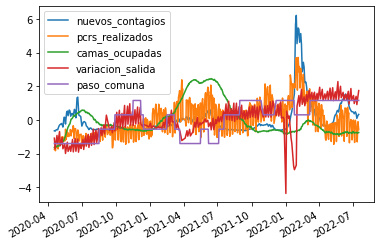

In [ ]:
# 2. Interpolar ciertos datos
print("A) Nuevos contagios")
print(f"  Si interpolamos cierta cantidad de datos podemos reducir el numero de NAs a:", pd.DataFrame({ str(i): data["nuevos_contagios"].interpolate(limit=i) for i in range(1,4)}).isna().sum(), sep="\n")

data["nuevos_contagios"] = data["nuevos_contagios"].interpolate(limit=3)

# print("B) Variacion_entrada")
# print(f"  Si interpolamos cierta cantidad de datos podemos reducir el numero de NAs a:", pd.DataFrame({ str(i): data["variacion_entrada"].interpolate(limit=i) for i in range(1,5)}).isna().sum(), sep="\n")

print("C) Variacion_salida")
print(f"  Si interpolamos cierta cantidad de datos podemos reducir el numero de NAs a:", pd.DataFrame({ str(i): data["variacion_salida"].interpolate(limit=i) for i in range(1,5)}).isna().sum(), sep="\n")

data["variacion_salida"] = data["variacion_salida"].interpolate(limit=3)

print("D) Paso_comuna")
print(" Ya que el paso a paso solo se reevalua una vez por semana podemos rellenar ciertos valores reduciendo el num de NAs a :", data["paso_comuna"].fillna(method='ffill').isna().sum())

data["paso_comuna"] = data["paso_comuna"].fillna(method='ffill') 


print(f"Fechas a usar deben estar entre {start_date} y {end_date}")
print("Rows with NA vs clean ones: ", list(data.isna().any(axis=1).value_counts()), "\n") # Cant de filas con y sin NA values
print(data.isna().sum(), "\n") # Cant de NA x col

data = data.dropna()
data = (data-data.mean())/data.std()

data.plot()

# Regresión Lineal

In [ ]:
from sklearn.metrics         import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model    import LinearRegression 

## No historical data

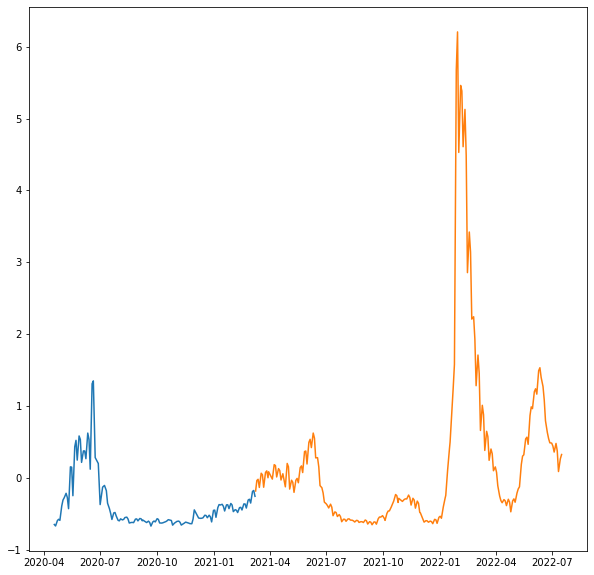

In [ ]:
X = data.drop(columns='nuevos_contagios').copy()
y = data['nuevos_contagios'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, shuffle=False)

plt.figure(figsize=(10,10))
plt.plot(y_train)
plt.plot(y_test)
plt.show()

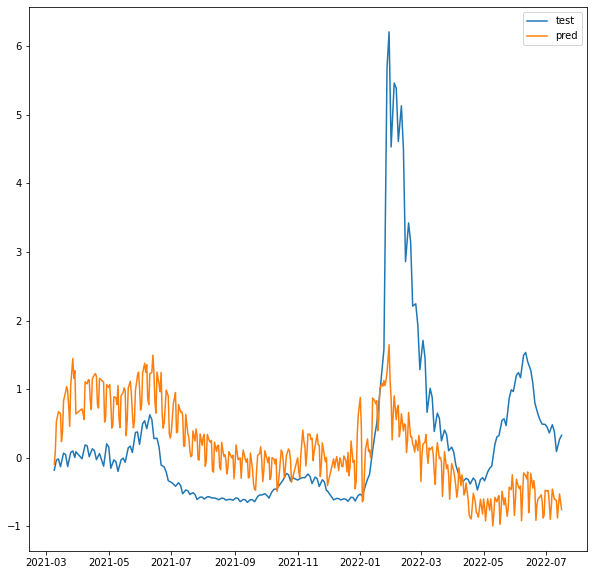

In [ ]:
reg = LinearRegression(fit_intercept=False)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

plt.figure(figsize=(10,10))

plt.plot(y_test.sort_index())
plt.plot(pd.Series(y_pred, index=y_test.index).sort_index())
plt.legend(['test','pred'])

plt.show()

In [ ]:
print( 'R2 Regressor = {:.2f}'.format( r2_score(y_test, y_pred) ) )
print( 'MAE Regressor = {:.2f}'.format( mean_absolute_error(y_test, y_pred) ) )
print( 'MSE Regressor = {:.2f}'.format(mean_squared_error(y_test, y_pred)) )

scores = cross_val_score(reg, X_test, y_test, cv=10)
print("cross_val: %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

R2 Regressor = -0.05
MAE Regressor = 0.90
MSE Regressor = 1.50
cross_val: -117.26 accuracy with a standard deviation of 262.47


## Add historical data

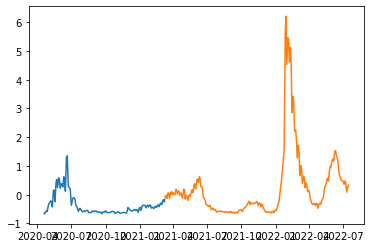

,pcrs_realizados,camas_ocupadas,variacion_salida,paso_comuna,previos_contagios
2020-04-19,-1.655469,-1.600125,-1.402036,-1.401802,-0.645048
2020-04-20,-1.681260,-1.568278,-1.721727,-1.401802,-0.655446
2020-04-21,-1.830303,-1.556029,-1.561500,-1.401802,-0.665844
2020-04-22,-1.598185,-1.579302,-1.401273,-1.401802,-0.640676
2020-04-23,-1.624753,-1.564603,-1.241047,-1.401802,-0.615508


2020-04-19   -0.655446
2020-04-20   -0.665844
2020-04-21   -0.640676
2020-04-22   -0.615508
2020-04-23   -0.590340
Name: nuevos_contagios, dtype: float64

In [ ]:
X = data.drop(columns='nuevos_contagios').copy()
X['previos_contagios'] = data['nuevos_contagios'].shift(periods=1)

X = X.iloc[1:]

y = data['nuevos_contagios'].copy().iloc[1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, shuffle=False)

plt.figure()
plt.plot(y_train)
plt.plot(y_test)
plt.show()

display(X.head())

display(y.head())

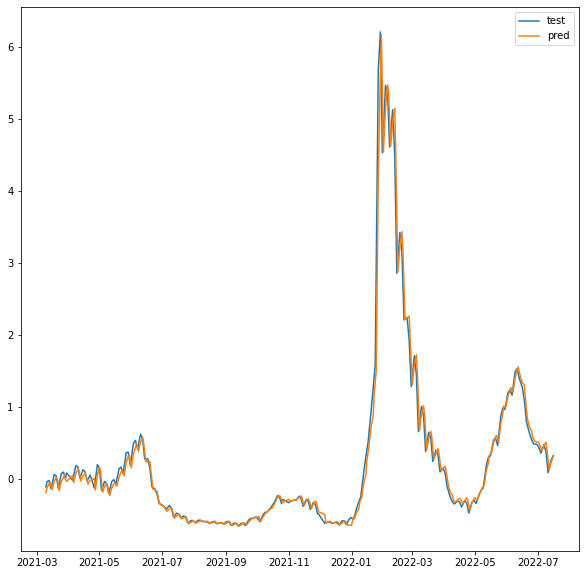

In [ ]:
reg = LinearRegression(fit_intercept=False)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

plt.figure(figsize=(10,10))
plt.plot(y_test.sort_index())
plt.plot(pd.Series(y_pred, index=y_test.index).sort_index())
plt.legend(['test','pred'])

plt.show()

In [ ]:
print( 'R2 Regressor = {:.2f}'.format( r2_score(y_test, y_pred) ) )
print( 'MAE Regressor = {:.2f}'.format( mean_absolute_error(y_test, y_pred) ) )
print( 'MSE Regressor = {:.2f}'.format(mean_squared_error(y_test, y_pred)) )

scores = cross_val_score(reg, X_test, y_test, cv=10)
print("cross_val: %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

a = pd.Series(y_pred, index=y_test.index)
print(" 'desfase' entre curvas es de: ~", (a[ a == a.max()].index- y_test[ y_test == y_test.max() ].index).days )

R2 Regressor = 0.98
MAE Regressor = 0.09
MSE Regressor = 0.03
cross_val: 0.01 accuracy with a standard deviation of 2.11
 'desfase' entre curvas es de: ~ Int64Index([1], dtype='int64')


## test with older dates

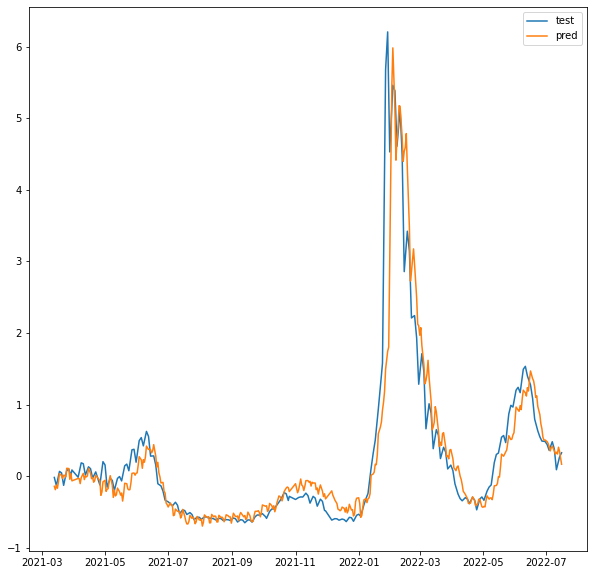

R2 Regressor = 0.84
MAE Regressor = 0.22
MSE Regressor = 0.24
cross_val: -5.87 accuracy with a standard deviation of 11.82


In [ ]:
N = 5
X = data.drop(columns='nuevos_contagios').copy()
X['previos_contagios'] = data['nuevos_contagios'].shift(periods=N)

X = X.iloc[N:]

y = data['nuevos_contagios'].copy().iloc[N:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, shuffle=False)

reg = LinearRegression(fit_intercept=False)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

plt.figure(figsize=(10,10))
plt.plot(y_test.sort_index())
plt.plot(pd.Series(y_pred, index=y_test.index).sort_index())
plt.legend(['test','pred'])

plt.show()

print( 'R2 Regressor = {:.2f}'.format( r2_score(y_test, y_pred) ) )
print( 'MAE Regressor = {:.2f}'.format( mean_absolute_error(y_test, y_pred) ) )
print( 'MSE Regressor = {:.2f}'.format(mean_squared_error(y_test, y_pred)) )

scores = cross_val_score(reg, X_test, y_test, cv=10)
print("cross_val: %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

## Generalización del modelo

In [ ]:
def train_comuna(nombre, train_ratio=0.4):
  curr_data = pd.DataFrame({ 
    "nuevos_contagios":  cov_new[nombre],         # Cada 2/3 dias
    "previos_contagios": cov_new[nombre].shift(),
    "pcrs_realizados":   cant_pcr,                 # Todos los dias
    "camas_ocupadas":    camas_criticas.ocupados,  # Todos los dias
    "variacion_salida":  var_salidas[nombre],
    "paso_comuna":       paso_a_paso[nombre]
  }).iloc[1:]

  # 1.
  start_date, end_date = max([ i.index.min() for i in datasets.values() ]), min([ i.index.max() for i in datasets.values() ])
  curr_data = curr_data.loc[start_date:end_date]
  # 2
  curr_data["nuevos_contagios"] = curr_data["nuevos_contagios"].interpolate(limit=3)
  curr_data["variacion_salida"] = curr_data["variacion_salida"].interpolate(limit=3)
  curr_data["paso_comuna"]      = curr_data["paso_comuna"].fillna(method='ffill') 

  curr_data = curr_data.dropna()
  curr_data = (curr_data - curr_data.mean()) / curr_data.std()

  split_index = round(curr_data.shape[0] * train_ratio)
 
  print(curr_data.drop(columns="nuevos_contagios").columns)
  reg = LinearRegression(fit_intercept=False)
  reg.fit(curr_data.drop(columns="nuevos_contagios").iloc[:split_index] , curr_data["nuevos_contagios"].iloc[:split_index])
 
  return reg
 
def train_all(train_ratio=0.4):
  comunas = DataProduct1.Comuna.drop_duplicates()

  regs = {}
  for i in comunas:
    if i in ['san pedro']:
      continue

    regs[i] = train_comuna(i, train_ratio)
  return regs

# Simulation cases

# Checking $\Delta$Contagios vs cambio de pasos

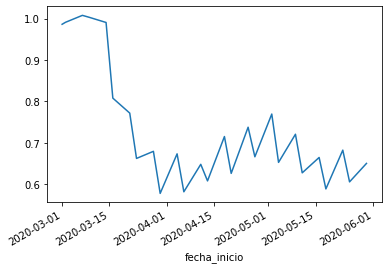

In [ ]:
var_salidas.santiago.loc[:'2020-05-31'].plot()

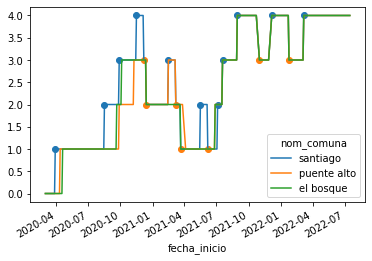

In [ ]:
com = paso_a_paso.santiago 
up_fase   = com - com.shift() ==  1
down_fase = com - com.shift() == -1

all_fases = pd.concat([com.loc[up_fase], com.loc[down_fase]]).to_frame().rename(columns={ 'santiago': 'fase' })
#all_fases["end_fase"]   = all_fases.start_fase.shift(periods=-1)

all_fases["which"] = all_fases.fase.isin(up_fase).astype(int)
all_fases = all_fases.reset_index()
all_fases["fecha_termino"] = all_fases.fecha_inicio.shift(periods=-1)
all_fases = all_fases.iloc[:-1]


fig, ax = plt.subplots()

#ax.scatter(down_fase, paso_a_paso.santiago.loc[down_fase])
paso_a_paso[["santiago", "puente alto", "el bosque"]].plot(ax=ax)

ax.scatter(paso_a_paso.santiago.loc[up_fase].index, paso_a_paso.santiago.loc[up_fase])
ax.scatter(paso_a_paso.santiago.loc[down_fase].index, paso_a_paso.santiago.loc[down_fase])

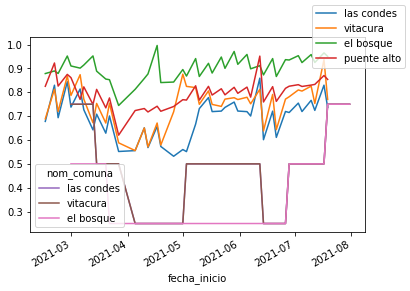

In [ ]:



fig, ax = plt.subplots()

# ax.scatter(all_fase.santiago.index, all_fase.santiago)
# paso_a_paso.santiago.plot(ax=ax)

#all_fases

#var_salidas.santiago[ var_salidas.santiago.between_time(*all_fases.iloc[-1][["fecha_inicio", "fecha_termino"]].values) ]
#all_fases.iloc[0][["fecha_inicio", "fecha_termino"]].values
for i in ["las condes", "vitacura", "el bosque", "puente alto"]:
  var_salidas[i].loc[all_fases.iloc[4].fecha_inicio: all_fases.iloc[6].fecha_termino].plot(ax=ax)

#paso_a_paso[["las condes", "vitacura", "el bosque", "puente alto"]].loc['2021-03-01':'2021:07:31'].plot(ax=ax)
(paso_a_paso / paso_a_paso.max() )[["las condes", "vitacura", "el bosque"]].loc['2021-03-01':'2021-07-31'].plot(ax=ax)
fig.legend(["las condes", "vitacura", "el bosque", "puente alto"])
